# Run Experiments

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
from skimage import feature, exposure
import colorsys
import os
import random
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision import transforms
# from pytorch_model_summary import summary

In [2]:
from utils import *
from HOG_and_DAISY_feature_extraction_methods import *

## Split the data into Train (and Validation) and a Test set

In [3]:
# # load all 30 classes, 220 images per class
# X, Y, idx_to_cl = load_dataset('data', cl_limit=30, img_limit=220)

# # train test split at 80-20 ratio
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True, random_state=42)

# print(f"Data shape: {X.shape}")
# print(f"Data labels shape: {Y.shape}\n")
# print(f"X Train shape: {X_train.shape}")
# print(f"Y Train shape: {Y_train.shape}")
# print(f"X Test shape: {X_test.shape}")
# print(f"Y Test shape: {Y_test.shape}")

# # save all as np
# folder_path = Path('train_test_split')
# folder_path.mkdir(parents=True, exist_ok=True)

# with open(folder_path / 'X_train.npy', 'wb') as f:
#     np.save(f, X_train)
# with open(folder_path / 'X_test.npy', 'wb') as f:
#     np.save(f, X_test)
# with open(folder_path / 'Y_train.npy', 'wb') as f:
#     np.save(f, Y_train)
# with open(folder_path / 'Y_test.npy', 'wb') as f:
#     np.save(f, Y_test)

In [3]:
# load in train and test data
folder_path = Path('train_test_split')

X_train = np.load(folder_path / 'X_train.npy')
Y_train = np.load(folder_path / 'Y_train.npy')
X_test = np.load(folder_path / 'X_test.npy')
Y_test = np.load(folder_path / 'Y_test.npy')

print(f"X Train shape: {X_train.shape}")
print(f"Y Train shape: {Y_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"Y Test shape: {Y_test.shape}")

X Train shape: (5280, 600, 600, 3)
Y Train shape: (5280,)
X Test shape: (1320, 600, 600, 3)
Y Test shape: (1320,)


In [ ]:
def process_features():
    """ """
    features, features_idxs = apply_features(X=X_test, feature_functions = {
        'temp': extract_hsv_features,
    })
    
    # save features
    feature_folder_path = Path('test_features')

    with open(feature_folder_path / 'HSV_features.npy', 'wb') as f:
        np.save(f, features)
        
# process_features()

100%|██████████| 1320/1320 [00:25<00:00, 51.86it/s]


## Plan
 - PCA variance explained
    - load in all features 
    - plot variance explained together
 - Pick a final feature set
    - do PCA
    - do t-SNE

In [4]:
def load_features():
    """ """
    feature_dict = {}
    features_dir = Path('features')
    for path in Path('features').iterdir():
        feature_name = path.stem
        feature_data = np.load(path)
        feature_dict[feature_name] = feature_data
    return feature_dict

In [5]:
feature_dict = load_features()

In [7]:
scaled_feature_dict = {}
for name, features in feature_dict.items():
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features)
    scaled_feature_dict[name] = features_train_scaled

In [8]:
for name in scaled_feature_dict.keys():
    print(name)

train_daisy_blue_features
train_daisy_gray_features
train_daisy_green_features
train_daisy_red_features
train_EffNet_features
train_HSV_features
train_large_blue_HOG_features
train_large_brightness_HOG_features
train_large_gray_HOG_features
train_large_green_HOG_features
train_large_hue_HOG_features
train_large_red_HOG_features
train_large_saturation_HOG_features
train_ResNet_features
train_RGB_features
train_small_blue_HOG_features
train_small_brightness_HOG_features
train_small_gray_HOG_features
train_small_green_HOG_features
train_small_hue_HOG_features
train_small_red_HOG_features
train_small_saturation_HOG_features


In [18]:
idx_to_cl = {
    0: 'Airport',
    1: 'BareLand',
    2: 'BaseballField',
    3: 'Beach',
    4: 'Bridge',
    5: 'Center',
    6: 'Church',
    7: 'Commercial',
    8: 'DenseResidential',
    9: 'Desert',
    10: 'Farmland',
    11: 'Forest',
    12: 'Industrial',
    13: 'Meadow',
    14: 'MediumResidential',
    15: 'Mountain',
    16: 'Park',
    17: 'Parking',
    18: 'Playground',
    19: 'Pond',
    20: 'Port',
    21: 'RailwayStation',
    22: 'Resort',
    23: 'River',
    24: 'School',
    25: 'SparseResidential',
    26: 'Square',
    27: 'Stadium',
    28: 'StorageTanks',
    29: 'Viaduct'
}

In [10]:
def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in range(len(np.unique(y))):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k], label="TODO")

  ax.set_title(title)
  plt.legend([v for k, v in sorted(idx_to_cl.items(), key=lambda item: item[0])], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [13]:
tsne_out = get_tsne([scaled_feature_dict["train_ResNet_features"], scaled_feature_dict["train_daisy_gray_features"]], n_components=2)
#daisy_gray_tsne = get_tsne([scaled_feature_dict["train_daisy_gray_features"]], n_components=2)
# resnet_tsne = get_tsne([scaled_feature_dict["train_ResNet_features"]], n_components=2)
# resnet_tsne = get_tsne([scaled_feature_dict["train_ResNet_features"]], n_components=2)
# resnet_tsne = get_tsne([scaled_feature_dict["train_ResNet_features"]], n_components=2)
# resnet_tsne = get_tsne([scaled_feature_dict["train_ResNet_features"]], n_components=2)

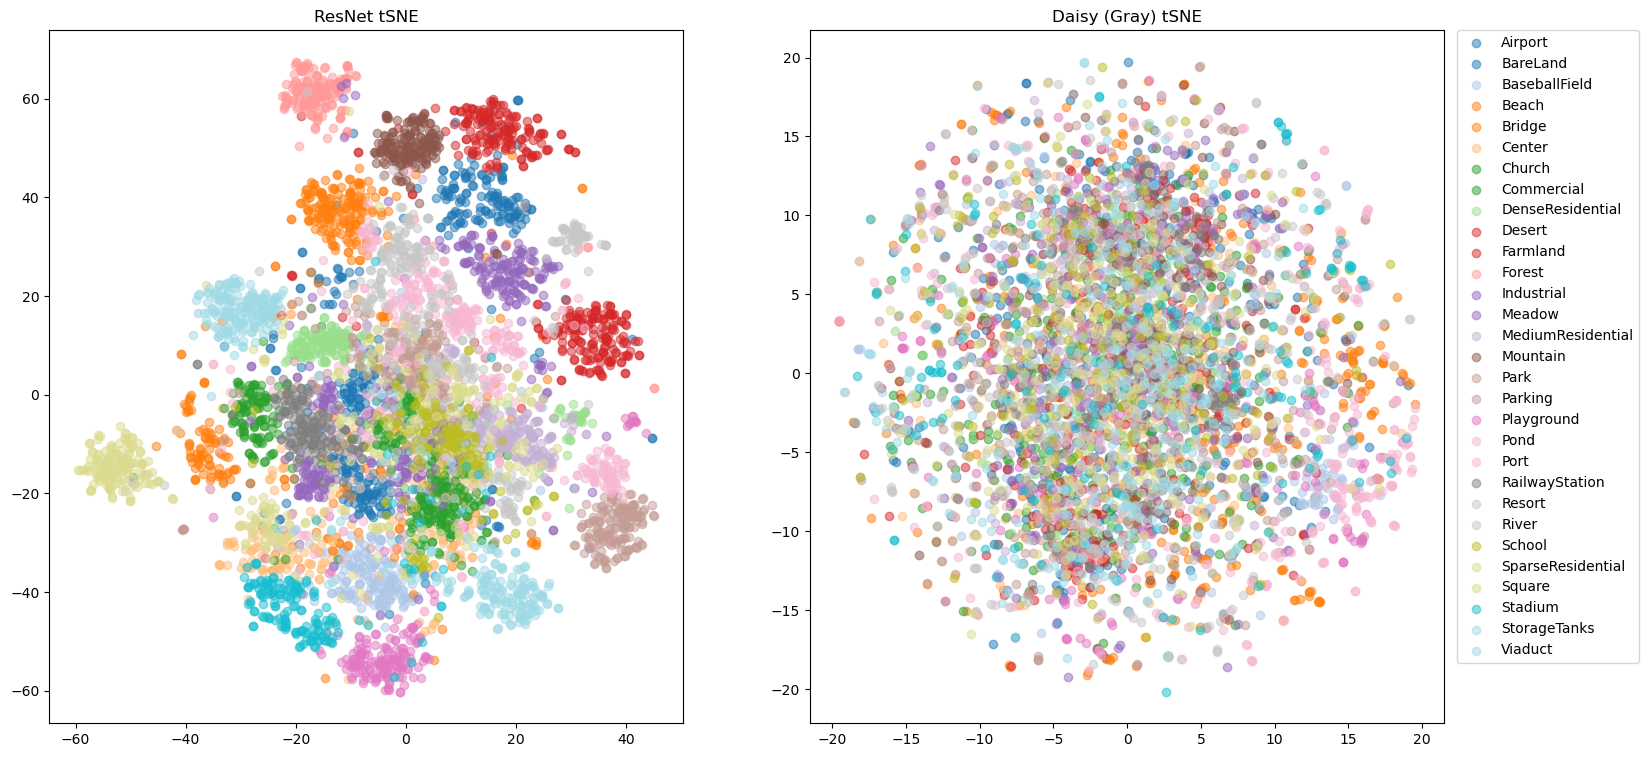

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,9))
plot_classes(tsne_out[0], Y_train, ax[0], title='{} tSNE'.format("ResNet"))
plot_classes(tsne_out[1], Y_train, ax[1], title='{} tSNE'.format("Daisy (Gray)"))
plt.show()

In [ ]:
# # features scaling
# scaler = StandardScaler()
# features_train_scaled = scaler.fit_transform(multiple_features) # replace input with whatever experiments we are doing
# # TODO: save this scaler for final features only

In [ ]:
# # PCA for features, use 95% explained variance for now
# pca = PCA(n_components=0.95)
# train_transformed = pca.fit_transform(features_train_scaled)
# print(train_transformed.shape)

# # TODO: save this pca model for final features

## Plan
 - iterate throught the feature_dict
    - for each feature set, train a Log Reg model
    - report accuracy, f1-weighted and time info

In [ ]:
def try_models(feature_dictionary, Y_train):
    """ """
    results_dict = {}
    for feature_name, feature_data in tqdm(feature_dictionary.items()):
        lr = LogisticRegression(
            penalty= "l2",
            tol = 1e-4,
            C=1.0,
            solver="lbfgs",
            max_iter=150,
            multi_class="multinomial",
            n_jobs=-1,
        )

        # replace experiment with whatever feature we are testing
        lr_model = cross_validate(lr, feature_data, Y_train, scoring=('f1_weighted','accuracy'), cv=10, n_jobs=-1)
        
        results_dict[feature_name] = lr_model
    
    return results_dict

In [ ]:
results_dict = try_models(feature_dict, Y_train)

In [ ]:
feature_names_list = []
fit_time_list = []
score_time_list = []
f1_list = []
accuracy_list = []

for feature_name, info_dict in results_dict.items():
   
    feature_names_list.append(feature_name)
    fit_time_list.append(np.mean(info_dict['fit_time']))
    score_time_list.append(np.mean(info_dict['score_time']))
    f1_list.append(np.mean(info_dict['test_f1_weighted']))
    accuracy_list.append(np.mean(info_dict['test_accuracy']))

In [ ]:
fill_dict = {
    "Feature_Name": feature_names_list,
    "Accuracy": accuracy_list,
    "F1_Score": f1_list,
    "Train_Time": fit_time_list,
    "Evaluate_Time": score_time_list,
}

results_df = pd.DataFrame(fill_dict)
results_df.sort_values(by=["Accuracy"], ascending=False)

In [ ]:
results_df.to_csv("Initial_Features_LogReg_results.csv")

## Features to Join
 - RGB, HSV
 - HOG (Small, Red), HOG (Large, Red), HOG (Small, Green), HOG (Large, Green), HOG (Small, Blue), HOG (Large, Blue)
 - HOG (Small, Gray), HOG (Large, Gray), HOG (Small, Hue), HOG (Large, Hue), HOG (Small, Saturation), HOG (Large, Saturation), HOG (Small, Brightness), HOG (Large, Brightness)
 - DAISY (Red), DAISY (Green), DAISY (Blue)
 - RGB, HSV, DAISY (Gray)
 - RGB, HSV, DAISY (Gray), ResNet

In [7]:
for name in feature_dict.keys():
    print(name)

train_daisy_blue_features
train_daisy_gray_features
train_daisy_green_features
train_daisy_red_features
train_EffNet_features
train_HSV_features
train_large_blue_HOG_features
train_large_brightness_HOG_features
train_large_gray_HOG_features
train_large_green_HOG_features
train_large_hue_HOG_features
train_large_red_HOG_features
train_large_saturation_HOG_features
train_ResNet_features
train_RGB_features
train_small_blue_HOG_features
train_small_brightness_HOG_features
train_small_gray_HOG_features
train_small_green_HOG_features
train_small_hue_HOG_features
train_small_red_HOG_features
train_small_saturation_HOG_features


In [12]:
RGB_DAISY_features = np.hstack((feature_dict['train_daisy_red_features'], feature_dict['train_daisy_green_features'], feature_dict['train_daisy_blue_features']))
RGB_DAISY_features.shape

(5280, 5400)

In [13]:
red_hog_features = np.hstack((feature_dict['train_small_red_HOG_features'], feature_dict['train_large_red_HOG_features']))
red_hog_features.shape

(5280, 9000)

In [14]:
green_hog_features = np.hstack((feature_dict['train_small_green_HOG_features'], feature_dict['train_large_green_HOG_features']))
green_hog_features.shape

(5280, 9000)

In [15]:
blue_hog_features = np.hstack((feature_dict['train_small_blue_HOG_features'], feature_dict['train_large_blue_HOG_features']))
blue_hog_features.shape

(5280, 9000)

In [16]:
gray_hog_features = np.hstack((feature_dict['train_small_gray_HOG_features'], feature_dict['train_large_gray_HOG_features']))
gray_hog_features.shape

(5280, 9000)

In [17]:
hue_hog_features = np.hstack((feature_dict['train_small_hue_HOG_features'], feature_dict['train_large_hue_HOG_features']))
hue_hog_features.shape

(5280, 9000)

In [18]:
saturation_hog_features = np.hstack((feature_dict['train_small_saturation_HOG_features'], feature_dict['train_large_saturation_HOG_features']))
saturation_hog_features.shape

(5280, 9000)

In [19]:
brightness_hog_features = np.hstack((feature_dict['train_small_brightness_HOG_features'], feature_dict['train_large_brightness_HOG_features']))
brightness_hog_features.shape

(5280, 9000)

In [6]:
RGB_HSV_features = np.hstack((feature_dict['train_RGB_features'], feature_dict['train_HSV_features']))
RGB_HSV_features.shape

(5280, 12)

In [21]:
# combo hog RGB
hog_RGB_features = np.hstack((red_hog_features, green_hog_features, blue_hog_features))
hog_RGB_features.shape

(5280, 27000)

In [ ]:
# combo hog gray + HSV
hog_gray_HSV_features = np.hstack((gray_hog_features, hue_hog_features, saturation_hog_features, brightness_hog_features))
hog_gray_HSV_features.shape

In [7]:
# RGB, HSV, ResNet
RGB_HSV_ResNet_features = np.hstack((RGB_HSV_features, feature_dict['train_ResNet_features']))
RGB_HSV_ResNet_features.shape

(5280, 2060)

In [23]:
# RGB, HSV, ResNet, Gray HOG
RGB_HSV_ResNet_GrayHOG_features = np.hstack((RGB_HSV_ResNet_features, gray_hog_features))
RGB_HSV_ResNet_GrayHOG_features.shape

(5280, 11060)

In [24]:
# with open('combined_train_features/train_RGB_HSV_ResNet_GrayHOG_features.npy', 'wb') as f:
#     np.save(f, RGB_HSV_ResNet_GrayHOG_features)

In [25]:
new_feature_combos_dict = {
    "DAISY (RGB)": RGB_DAISY_features,
    "HOG Multi-Scale (Red)": red_hog_features,
    "HOG Multi-Scale (Green)": green_hog_features,
    "HOG Multi-Scale (Blue)": blue_hog_features,
    "HOG Multi-Scale (Gray)": gray_hog_features,
    "HOG Multi-Scale (Hue)": hue_hog_features,
    "HOG Multi-Scale (Saturation)": saturation_hog_features,
    "HOG Multi-Scale (Brightness)": brightness_hog_features,
    "RGB + HSV": RGB_HSV_features,
    "HOG Multi-Scale (RGB)": hog_RGB_features,
    # "HOG Multi-Scale (Gray+HSV)": hog_gray_HSV_features,
    "RGB + HSV + ResNet": RGB_HSV_ResNet_features,
    "RGB + HSV + ResNet + HOG (Gray)": RGB_HSV_ResNet_GrayHOG_features,
}

In [26]:
scaled_new_feature_combos_dict = {}
for name, features in new_feature_combos_dict.items():
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features)
    scaled_new_feature_combos_dict[name] = features_train_scaled

In [27]:
tsne_out = get_tsne(X_list=[
    scaled_new_feature_combos_dict["RGB + HSV"],
    scaled_new_feature_combos_dict["DAISY (RGB)"],
    scaled_new_feature_combos_dict["HOG Multi-Scale (Gray)"],
    scaled_new_feature_combos_dict["HOG Multi-Scale (RGB)"],
    scaled_feature_dict["train_ResNet_features"], 
    scaled_new_feature_combos_dict["RGB + HSV + ResNet + HOG (Gray)"],
    ], 
    n_components=2
)

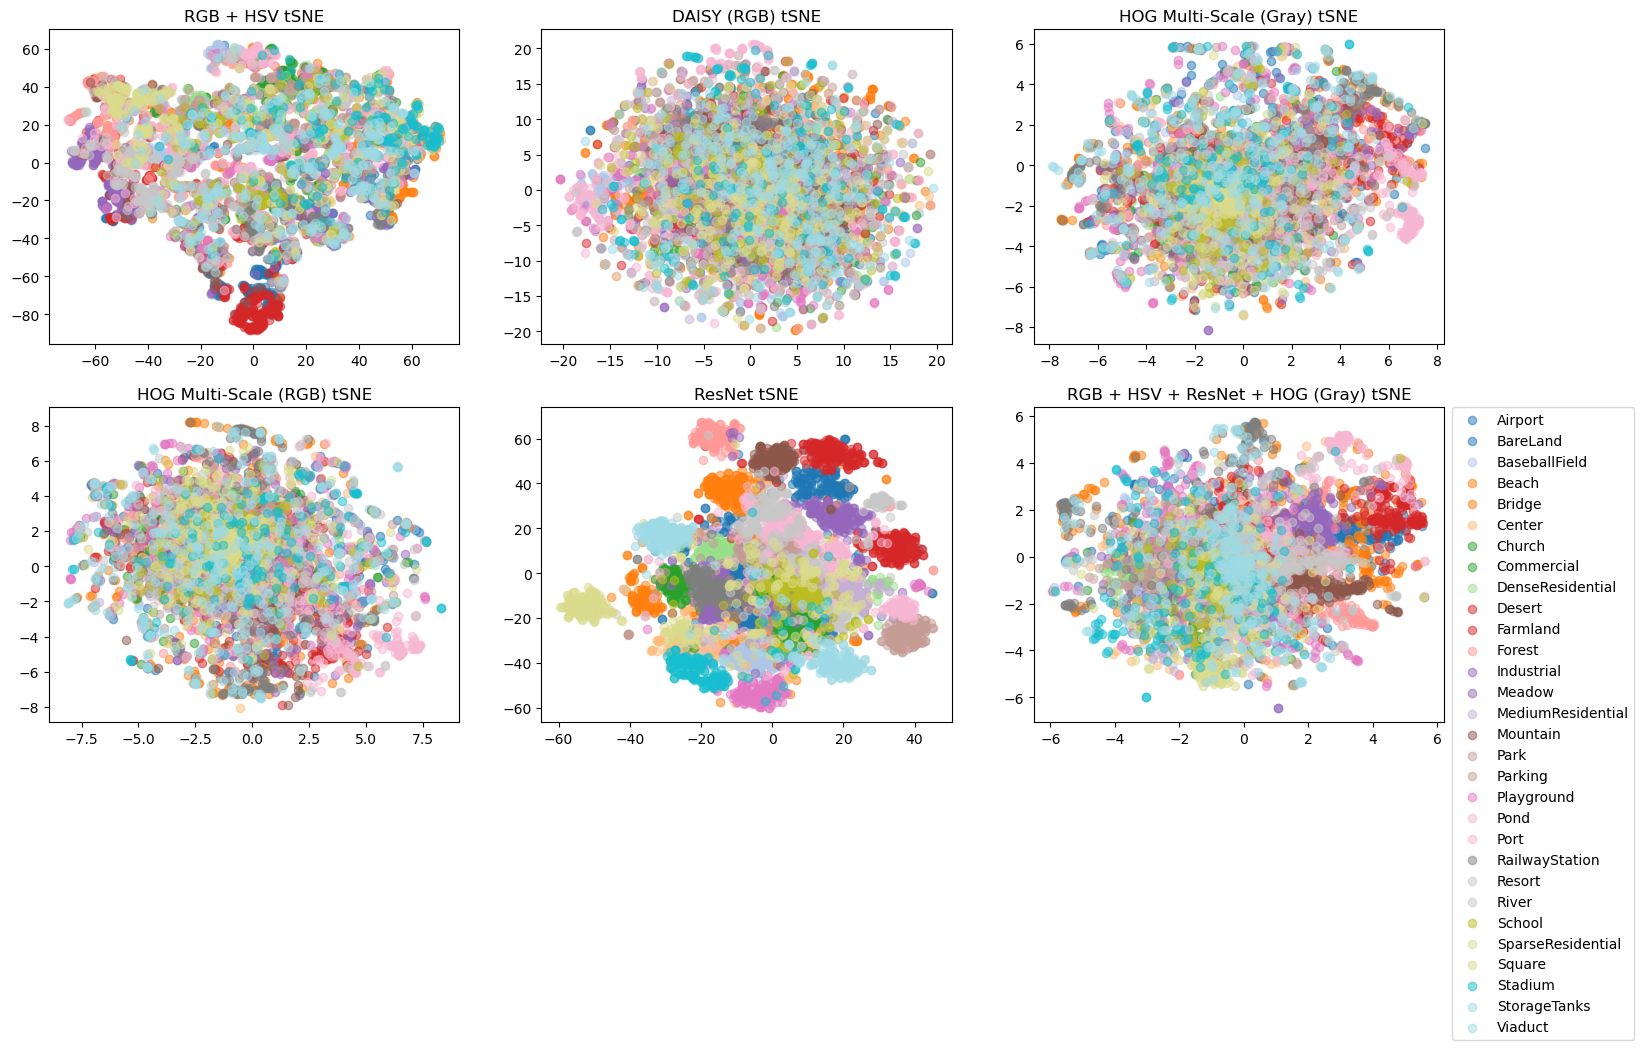

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,9))
plot_classes(tsne_out[0], Y_train, ax[0,0], title='{} tSNE'.format("RGB + HSV"))
plot_classes(tsne_out[1], Y_train, ax[0,1], title='{} tSNE'.format("DAISY (RGB)"))
plot_classes(tsne_out[2], Y_train, ax[0,2], title='{} tSNE'.format("HOG Multi-Scale (Gray)"))
plot_classes(tsne_out[3], Y_train, ax[1,0], title='{} tSNE'.format("HOG Multi-Scale (RGB)"))
plot_classes(tsne_out[4], Y_train, ax[1,1], title='{} tSNE'.format("ResNet"))
plot_classes(tsne_out[5], Y_train, ax[1,2], title='{} tSNE'.format("RGB + HSV + ResNet + HOG (Gray)"))
plt.show()

In [22]:
pca_feature_combos_dict = {}
for name, scaled_features in scaled_new_feature_combos_dict.items():
    pca = PCA(n_components=0.95)
    train_transformed = pca.fit_transform(scaled_features)
    pca_feature_combos_dict[name] = train_transformed

In [ ]:
# # PCA for features, use 95% explained variance for now
# pca = PCA(n_components=0.95)
# train_transformed = pca.fit_transform(features_train_scaled)
# print(train_transformed.shape)

# # TODO: save this pca model for final features

In [23]:
def try_models(feature_dictionary, Y_train):
    """ """
    results_dict = {}
    for feature_name, feature_data in tqdm(feature_dictionary.items()):
        lr = LogisticRegression(
            penalty= "l2",
            tol = 1e-4,
            C=1.0,
            solver="lbfgs",
            max_iter=150,
            multi_class="multinomial",
            n_jobs=-1,
        )

        # replace experiment with whatever feature we are testing
        lr_model = cross_validate(lr, feature_data, Y_train, scoring=('f1_weighted','accuracy'), cv=10, n_jobs=-1)
        
        results_dict[feature_name] = lr_model
    
    return results_dict

In [24]:
results_dict = try_models(pca_feature_combos_dict, Y_train)

100%|██████████| 11/11 [02:34<00:00, 14.01s/it]


In [25]:
feature_names_list = []
fit_time_list = []
score_time_list = []
f1_list = []
accuracy_list = []

for feature_name, info_dict in results_dict.items():
   
    feature_names_list.append(feature_name)
    fit_time_list.append(np.mean(info_dict['fit_time']))
    score_time_list.append(np.mean(info_dict['score_time']))
    f1_list.append(np.mean(info_dict['test_f1_weighted']))
    accuracy_list.append(np.mean(info_dict['test_accuracy']))

In [26]:
fill_dict = {
    "Feature_Name": feature_names_list,
    "Accuracy": accuracy_list,
    "F1_Score": f1_list,
    "Train_Time": fit_time_list,
    "Evaluate_Time": score_time_list,
}

results_df = pd.DataFrame(fill_dict)
results_df = results_df.sort_values(by=["Accuracy"], ascending=False)

In [27]:
results_df

,Feature_Name,Accuracy,F1_Score,Train_Time,Evaluate_Time
9,RGB + HSV + ResNet,0.911364,0.910937,7.883818,0.006987
10,RGB + HSV + ResNet + HOG (Gray),0.870265,0.869275,18.458094,0.007677
8,RGB + HSV,0.317992,0.283789,0.621883,0.003264
5,HOG Multi-Scale (Hue),0.296402,0.294302,15.655695,0.008244
2,HOG Multi-Scale (Green),0.290152,0.283225,17.648750,0.007569
4,HOG Multi-Scale (Gray),0.288636,0.284148,17.123555,0.009589
1,HOG Multi-Scale (Red),0.282386,0.277467,16.060850,0.009861
7,HOG Multi-Scale (Brightness),0.281629,0.275488,16.902550,0.008297
3,HOG Multi-Scale (Blue),0.277273,0.271179,17.314521,0.008694
0,DAISY (RGB),0.253788,0.245344,2.068286,0.003908


In [28]:
results_df.to_csv("Combo_Features_LogReg_results.csv")

In [8]:
RGB_HSV_ResNet_features.shape

(5280, 2060)

In [9]:
scaler = StandardScaler()
RGB_HSV_ResNet_features_scaled = scaler.fit_transform(RGB_HSV_ResNet_features)

In [10]:
pca = PCA(n_components=0.95)
RGB_HSV_ResNet_features_scaled_transformed = pca.fit_transform(RGB_HSV_ResNet_features_scaled)
RGB_HSV_ResNet_features_scaled_transformed.shape

(5280, 1250)

In [15]:
lr = LogisticRegression()
lr_params = {
    'penalty':['l1','l2'],
    'tol':[1e-5, 1e-4, 1e-3, 1e-2],
    'C':[0.2, 0.5, 1.0, 1.5, 2],
    'max_iter':[50,100,150,200]
}

lr_model = GridSearchCV(lr, lr_params)
lr_model.fit(RGB_HSV_ResNet_features_scaled_transformed, Y_train)

c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.2, 0.5, 1.0, 1.5, 2],
                         'max_iter': [50, 100, 150, 200],
                         'penalty': ['l1', 'l2'],
                         'tol': [1e-05, 0.0001, 0.001, 0.01]})

In [11]:
# get test data
test_data_dir_path = Path("test_features")
test_RGB_features = np.load(test_data_dir_path / "RGB_features.npy")
test_HSV_features = np.load(test_data_dir_path / "HSV_features.npy")
test_ResNet_features = np.load(test_data_dir_path / "test_ResNet_features.npy")

In [12]:
test_features = np.hstack((test_RGB_features, test_HSV_features, test_ResNet_features))
test_features.shape

(1320, 2060)

In [13]:
test_features_scaled = scaler.transform(test_features)

In [14]:
test_features_scaled_transformed = pca.transform(test_features_scaled)
test_features_scaled_transformed.shape

(1320, 1250)

In [22]:
lr_model.score(RGB_HSV_ResNet_features_scaled_transformed, Y_train)

1.0

In [27]:
%%time
lr_model.score(test_features_scaled_transformed, Y_test)

CPU times: total: 0 ns
Wall time: 5 ms


0.9143939393939394

In [26]:
lr_model.refit_time_

2.6681840419769287

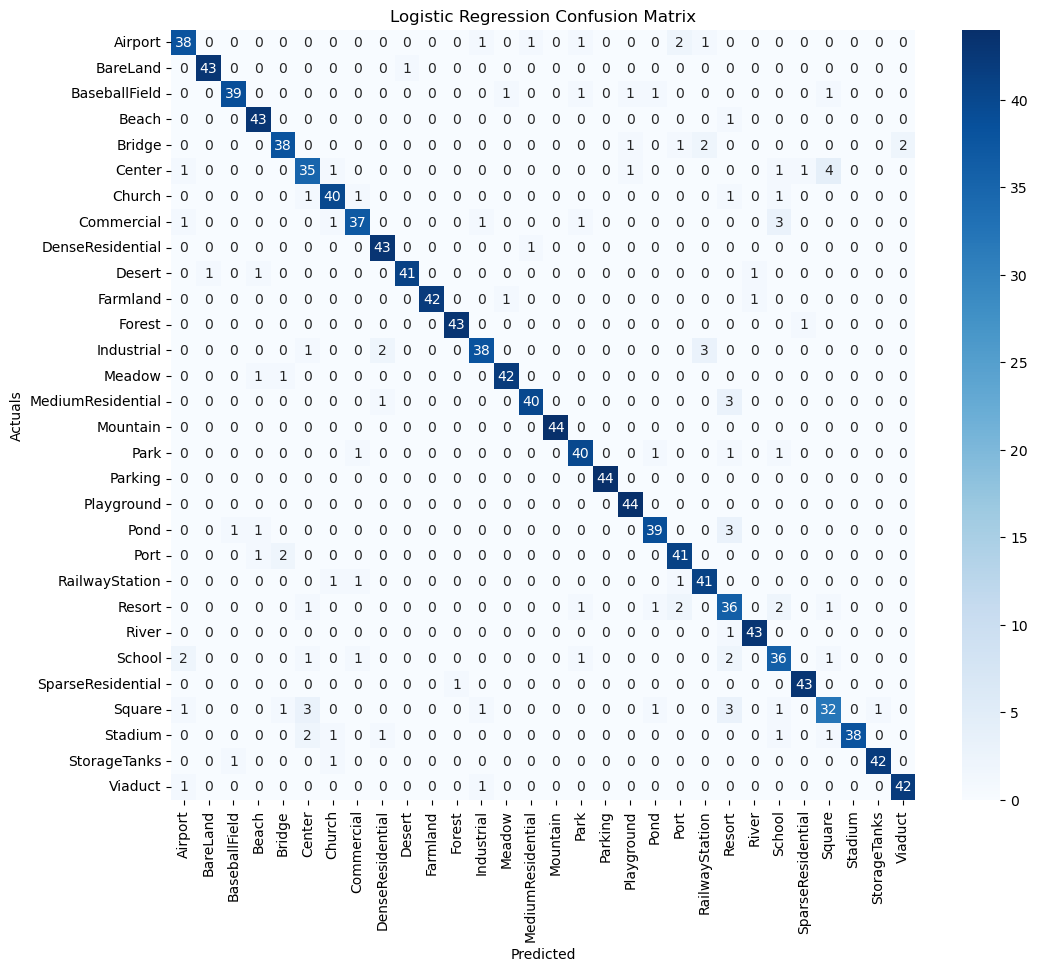

In [20]:
# deriving confusion matrix from Y prediction of test set
Y_pred = lr_model.predict(test_features_scaled_transformed)
conf_matrix = confusion_matrix(Y_test, Y_pred)
labels = [x for _, x in sorted(zip(idx_to_cl.keys(), idx_to_cl.values()))]
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# plotting confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(conf_df, annot=True, cmap="Blues")
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actuals')
plt.xlabel('Predicted')
plt.show()